### FFT Plots OTB+ HD_sEMG Data

This script performs a Fast Fourier Transformation (FFT) to plot OTB+ HD_sEMG Signals in the Frequency Domain.

[INFO] Loading Raw Unfiltered (Trimmed) Data...
[WARNING] Processed file not found: C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(3)\Processed EMG Data\Processed OTB+\processed_emg_data_20241028_152934374_bad_channels_zeroed.npy. Skipping Bad Channels Zeroed.
[WARNING] Processed file not found: C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(3)\Processed EMG Data\Processed OTB+\processed_emg_data_20241028_152934374_spike_removed.npy. Skipping Spike Removed.
[INFO] Loading Filtered EMG...
[INFO] Loading Bipolar Signals...
[INFO] Loading Rectified Signals...
[INFO] Loading EMG Envelope...
[INFO] Loading Normalized EMG...
[INFO] Computing FFT for Raw Unfiltered (Trimmed)...
[INFO] Computing FFT for Filtered EMG...
[INFO] Computing FFT for Bipolar Signals...
[INFO] Computing FFT for Rectified Signals...
[INFO] Computing FFT for EMG Envelope...
[INFO] Computing FFT for Normalized EMG...


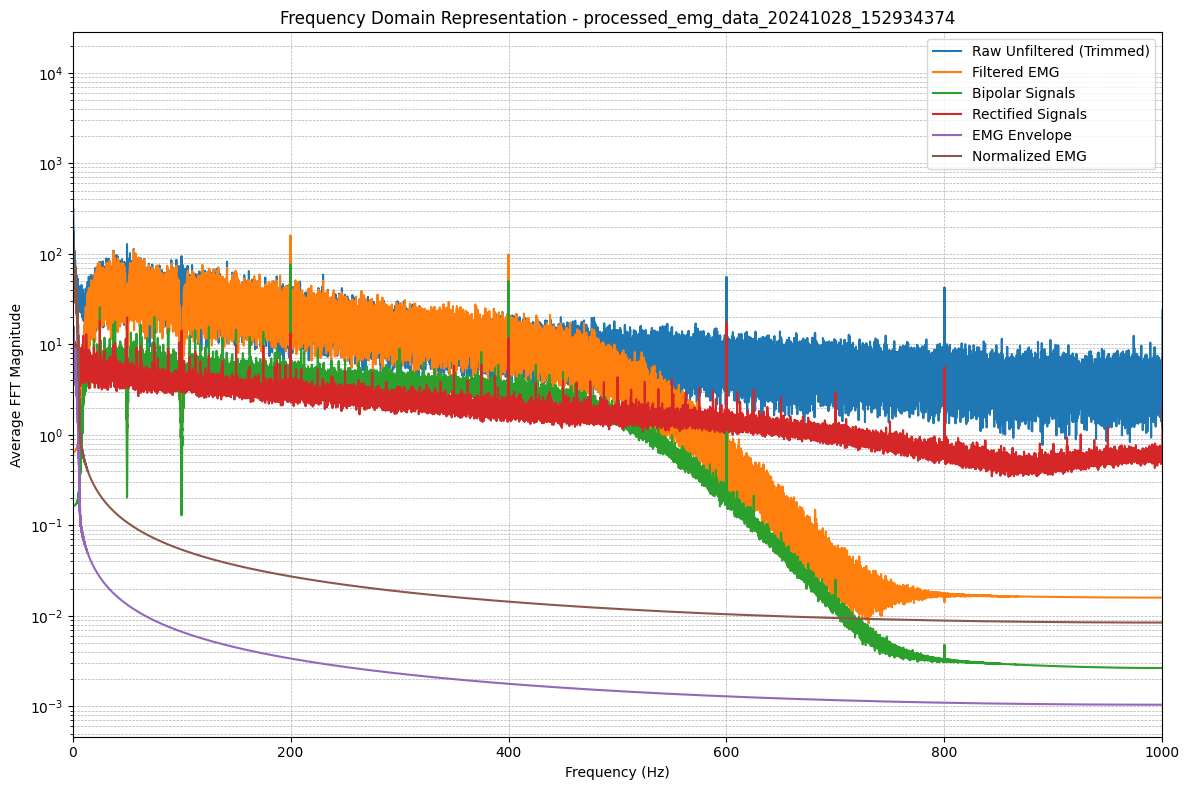

[INFO] Frequency domain plot saved to C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(3)\Processed EMG Data\Processed OTB+\processed_emg_data_20241028_152934374_frequency_domain.png


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
import os

def plot_frequency_steps_single_file(raw_csv_path, processed_folder, processed_filename_base, fs=2000, use_log_scale=True, normalize=False, trim_duration=1):
    """
    Plot the frequency domain representations of all processing steps for a single EMG file.

    Parameters:
    - raw_csv_path (str): Path to the raw EMG .csv file.
    - processed_folder (str): Directory where processed .npy files are stored.
    - processed_filename_base (str): Base name of the processed files (without suffix and extension).
    - fs (int): Sampling frequency in Hz. Default is 2000 Hz.
    - use_log_scale (bool): If True, use a logarithmic scale for the y-axis.
    - normalize (bool): If True, normalize each processing step's FFT magnitude by its maximum value.
    - trim_duration (float): Duration in seconds to trim from the start of the raw data. Default is 0.2 seconds.

    Processing Steps to Plot:
    1. Raw Unfiltered (Trimmed)
    2. Bad Channels Zeroed
    3. Spike Removed
    4. Filtered EMG
    5. Bipolar Signals
    6. Rectified Signals
    7. EMG Envelope
    8. Normalized EMG

    The function will generate a single plot with multiple lines, each representing a processing step.
    """

    # Define the processed data types and their corresponding suffixes
    processed_types = {
        'Raw Unfiltered (Trimmed)': None,  # Special handling for raw data
        'Bad Channels Zeroed': 'bad_channels_zeroed',
        'Spike Removed': 'spike_removed',
        'Filtered EMG': 'cleaned_hd_emg',
        'Bipolar Signals': 'bipolar_hd_emg',
        'Rectified Signals': 'rectified_emg',
        'EMG Envelope': 'envelope_emg',
        'Normalized EMG': 'normalized_emg'
    }

    # Initialize a dictionary to hold signals for each step
    signals = {}

    # 1. Load Raw Unfiltered (Trimmed) Data
    try:
        print("[INFO] Loading Raw Unfiltered (Trimmed) Data...")
        # Load raw data
        raw_data = pd.read_csv(raw_csv_path, delimiter=',', header=None).to_numpy()
        # Trim the first 'trim_duration' seconds
        trim_samples = int(trim_duration * fs)
        if raw_data.shape[0] > trim_samples:
            raw_data = raw_data[trim_samples:, :]
        else:
            print("[WARNING] Raw data has fewer samples than the trim duration. Skipping this file.")
            return
        # Transpose to shape (channels, samples)
        signals['Raw Unfiltered (Trimmed)'] = raw_data.T  # Shape: (channels, samples)
    except Exception as e:
        print(f"[ERROR] Failed to load raw data: {e}")
        return

    # 2. Load Processed Data Steps
    for step_name, suffix in processed_types.items():
        if step_name == 'Raw Unfiltered (Trimmed)':
            continue  # Already loaded
        if suffix is None:
            continue  # No suffix defined
        file_suffix = f"{suffix}.npy"
        file_path = os.path.join(processed_folder, f"{processed_filename_base}_{file_suffix}")
        if not os.path.exists(file_path):
            print(f"[WARNING] Processed file not found: {file_path}. Skipping {step_name}.")
            continue
        try:
            print(f"[INFO] Loading {step_name}...")
            data = np.load(file_path)
            signals[step_name] = data
        except Exception as e:
            print(f"[ERROR] Failed to load {step_name}: {e}")
            continue

    # Ensure all signals have the same number of samples
    min_samples = min([sig.shape[1] for sig in signals.values()])
    for key in signals:
        signals[key] = signals[key][:, :min_samples]

    # Compute FFTs
    fft_results = {}
    for step_name, data in signals.items():
        print(f"[INFO] Computing FFT for {step_name}...")
        # Compute FFT Magnitude for each channel
        fft_magnitude = np.abs(np.fft.rfft(data, axis=1))
        freqs = np.fft.rfftfreq(min_samples, d=1/fs)
        # Average FFT magnitude across channels
        avg_fft = np.mean(fft_magnitude, axis=0)
        if normalize:
            if np.max(avg_fft) == 0:
                print(f"[WARNING] Max FFT magnitude for {step_name} is zero. Skipping normalization.")
                fft_results[step_name] = (freqs, avg_fft)
            else:
                avg_fft = avg_fft / np.max(avg_fft)
                fft_results[step_name] = (freqs, avg_fft)
        else:
            fft_results[step_name] = (freqs, avg_fft)

    # Plotting
    plt.figure(figsize=(12, 8))
    for step_name, (freqs, avg_fft) in fft_results.items():
        if use_log_scale:
            plt.semilogy(freqs, avg_fft, label=step_name)
        else:
            plt.plot(freqs, avg_fft, label=step_name)

    plt.title(f'Frequency Domain Representation - {processed_filename_base}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average FFT Magnitude' if not normalize else 'Normalized Average FFT Magnitude')
    plt.xlim(0, fs/2)
    plt.legend()
    if use_log_scale:
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    else:
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the plot
    plot_filename = f"{processed_filename_base}_frequency_domain.png"
    plot_path = os.path.join(processed_folder, plot_filename)
    plt.savefig(plot_path)
    plt.show()
    print(f"[INFO] Frequency domain plot saved to {plot_path}")



# ------------------------------------------------------
# Example for Participant 7
# ------------------------------------------------------

if __name__ == "__main__":
    # Example parameters for Participant 7
    participant = 3
    base_path = r"C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data"
    participant_folder = os.path.join(base_path, f"P({participant})")
    otb_plus_folder = os.path.join(participant_folder, "otb+")

    # Example raw file (replace with your actual file)
    raw_filename = "emg_data_20241028_152934374.csv"  # Replace with your actual raw file name
    raw_csv_path = os.path.join(otb_plus_folder, raw_filename)

    # Corresponding processed files are assumed to be in 'Processed EMG Data\Processed OTB+' folder
    processed_folder = os.path.join(participant_folder, "Processed EMG Data", "Processed OTB+")
    processed_filename_base = f"processed_{os.path.splitext(raw_filename)[0]}"  # e.g., "processed_emg_data_20230415_101530000"

    # Call the plotting function
    plot_frequency_steps_single_file(
        raw_csv_path=raw_csv_path,
        processed_folder=processed_folder,
        processed_filename_base=processed_filename_base,
        fs=2000  # Sampling frequency in Hz
    )
